In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
#import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
import warnings
import cv2
warnings.filterwarnings('ignore')

____________________________
### Read  Images and Store in Dictionary

In [110]:
from os import listdir
from os.path import isfile, join
mypath = '/Users/phakjira/Desktop/cv_airdrop_yen/'
patients = [[f,join(mypath, f)] for f in listdir(mypath) if(f!='.DS_Store')]
patients.sort()

adc = {}
cor = {}
hbv = {}
sag = {}
t2w = {}
for patient,dir in patients:
    file = [join(dir, f) for f in listdir(dir) if(f!='.DS_Store')]
    file.sort()

    # print(patient)
    # print(file)

    adc_img = sitk.ReadImage(file[0])
    adc[patient] = sitk.GetArrayFromImage(adc_img)

    cor_img = sitk.ReadImage(file[1])
    cor[patient] = sitk.GetArrayFromImage(cor_img)

    hbv_img = sitk.ReadImage(file[2])
    hbv[patient] = sitk.GetArrayFromImage(hbv_img)

    sag_img = sitk.ReadImage(file[3])
    sag[patient] = sitk.GetArrayFromImage(sag_img)

    t2w_img = sitk.ReadImage(file[4])
    t2w[patient] = sitk.GetArrayFromImage(t2w_img)

all_data = {'adc':adc, 'cor':cor, 'hbv':hbv, 'sag':sag, 't2w':t2w}

In [68]:
test = sitk.ReadImage('/Users/phakjira/Desktop/cv_airdrop_yen/10033/10033_1000033_cor.mha')

In [69]:
sitk.GetArrayFromImage(test).shape

(104, 256, 256)

### Find Maximum Number of Channel Dimensions

In [111]:
max_channel_dict = {}
for type in all_data.keys():
    print(type)
    img_dict = all_data[type]
    channels = {}
    for i in img_dict.keys():
        channels[i] = img_dict[i].shape[0]

    # find max channels value and its corresponding key
    max_channel = max(channels.values())
    max_channel_key = max(channels, key=channels.get)

    per_95_channel = np.percentile(np.array(list(channels.values())),95)
    per_95_channel = int(per_95_channel)

    min_channel = min(channels.values())

    # print out the max channel and its corresponding key
    print('Maximum channels = ', max_channel)
    # print('Maximum channels image set = ', max_channel_key)
    # print('Shape = ', img_dict[max_channel_key].shape)
    print('Minimum channels = ', min_channel)
    print('95th percentile channels = ', per_95_channel)
    print('')
    max_channel_dict[type] = max_channel


adc
Maximum channels =  31
Minimum channels =  16
95th percentile channels =  28

cor
Maximum channels =  104
Minimum channels =  15
95th percentile channels =  44

hbv
Maximum channels =  31
Minimum channels =  16
95th percentile channels =  28

sag
Maximum channels =  31
Minimum channels =  19
95th percentile channels =  31

t2w
Maximum channels =  31
Minimum channels =  19
95th percentile channels =  28



### Apply Zero Padding Channel-Wise until Maximum Channel Shape

In [112]:
for type in all_data.keys():
    print(type)
    img_dict = all_data[type]
    for i in img_dict.keys():
        if img_dict[i].shape[0] < max_channel:

            # compute difference between maximum and current number of channels
            diff = max_channel - img_dict[i].shape[0]

            # create 3d image with channels = diff, height = shape[1], width = shape[2]
            zero_img = np.zeros((diff, img_dict[i].shape[1], img_dict[i].shape[2]))

            # concatenate along dimension 0
            img_dict[i] = np.concatenate((img_dict[i], zero_img), axis=0)

            # print shape
            print('Patient = ', i)
            print('Shape = ', img_dict[i].shape)

adc
Patient =  10001
Shape =  (31, 128, 120)
Patient =  10003
Shape =  (31, 128, 120)
Patient =  10006
Shape =  (31, 128, 120)
Patient =  10017
Shape =  (31, 128, 84)
Patient =  10020
Shape =  (31, 128, 120)
Patient =  10022
Shape =  (31, 256, 256)
Patient =  10023
Shape =  (31, 128, 88)
Patient =  10027
Shape =  (31, 256, 256)
Patient =  10029
Shape =  (31, 128, 120)
Patient =  10032
Shape =  (31, 128, 84)
Patient =  10033
Shape =  (31, 128, 120)
Patient =  10035
Shape =  (31, 224, 224)
Patient =  10038
Shape =  (31, 128, 120)
Patient =  10040
Shape =  (31, 128, 84)
Patient =  10041
Shape =  (31, 256, 256)
cor
Patient =  10000
Shape =  (31, 640, 640)
Patient =  10001
Shape =  (31, 320, 320)
Patient =  10003
Shape =  (31, 320, 320)
Patient =  10006
Shape =  (31, 320, 320)
Patient =  10017
Shape =  (31, 320, 320)
Patient =  10020
Shape =  (31, 320, 320)
Patient =  10022
Shape =  (31, 720, 720)
Patient =  10023
Shape =  (31, 320, 320)
Patient =  10027
Shape =  (31, 320, 320)
Patient =  1

In [106]:
adc.keys()

dict_keys(['10000', '10001', '10003', '10006', '10017', '10020', '10022', '10023', '10027', '10029', '10032', '10033', '10035', '10038', '10040', '10041'])

### Find Minimum Dimensions in Height (Shape[1]) and Width (Shape[2])

In [90]:
for type in all_data.keys():
    print(type)
    img_dict = all_data[type]
    min_height = min([img_dict[i].shape[1] for i in img_dict.keys()])
    min_height_key = min(img_dict, key=lambda x: img_dict[x].shape[1])

    print('Minimum height = ', min_height)
    print('Minimum height image set = ', min_height_key)

    max_height = max([img_dict[i].shape[1] for i in img_dict.keys()])
    max_height_key = max(img_dict, key=lambda x: img_dict[x].shape[1])

    print('Maximum height = ', max_height)
    print('Maximum height image set = ', max_height_key)
    print('')

    min_width = min([img_dict[i].shape[2] for i in img_dict.keys()])
    min_width_key = min(img_dict, key=lambda x: img_dict[x].shape[2])

    print('Minimum width = ', min_width)
    print('Minimum width image set = ', min_width_key)

    max_width = max([img_dict[i].shape[2] for i in img_dict.keys()])
    max_width_key = max(img_dict, key=lambda x: img_dict[x].shape[2])

    print('Maximum width = ', max_width)
    print('Maximum width image set = ', max_width_key)
    print('')

adc
Minimum height =  114
Minimum height image set =  10000
Maximum height =  256
Maximum height image set =  10022

Minimum width =  84
Minimum width image set =  10017
Maximum width =  256
Maximum width image set =  10022

cor
Minimum height =  256
Minimum height image set =  10033
Maximum height =  720
Maximum height image set =  10022

Minimum width =  256
Minimum width image set =  10033
Maximum width =  720
Maximum width image set =  10022

hbv
Minimum height =  114
Minimum height image set =  10000
Maximum height =  256
Maximum height image set =  10022

Minimum width =  84
Minimum width image set =  10017
Maximum width =  256
Maximum width image set =  10022

sag
Minimum height =  320
Minimum height image set =  10001
Maximum height =  864
Maximum height image set =  10022

Minimum width =  320
Minimum width image set =  10001
Maximum width =  864
Maximum width image set =  10022

t2w
Minimum height =  320
Minimum height image set =  10023
Maximum height =  1024
Maximum height 

In [115]:
for patient in adc.keys():
    print(adc[patient].shape)

(31, 114, 116)
(31, 128, 120)
(31, 128, 120)
(31, 128, 120)
(31, 128, 84)
(31, 128, 120)
(31, 256, 256)
(31, 128, 88)
(31, 256, 256)
(31, 128, 120)
(31, 128, 84)
(31, 128, 120)
(31, 224, 224)
(31, 128, 120)
(31, 128, 84)
(31, 256, 256)


(31, 128, 120)
(256, 256)


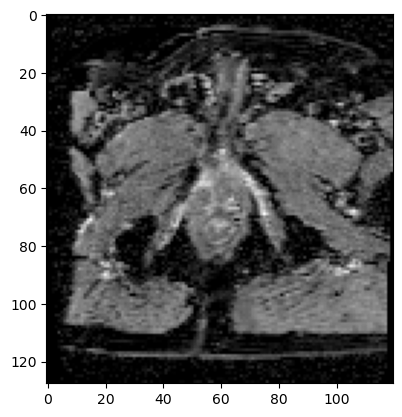

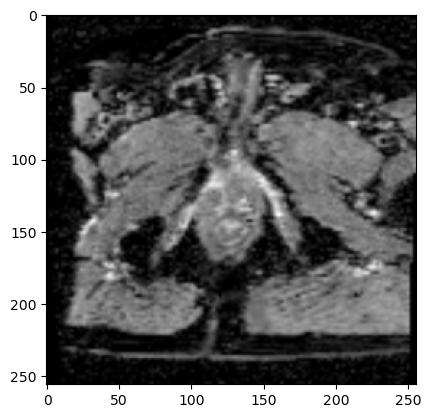

In [114]:
test_image = adc['10001']
print(test_image.shape)

resize = cv2.resize(test_image[0], (256, 256))
print(resize.shape)

plt.imshow(test_image[0], cmap='gray')
plt.show()

plt.imshow(resize, cmap='gray')
plt.show()

(31, 128, 84)
(256, 256)


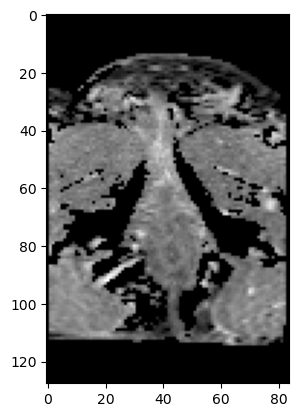

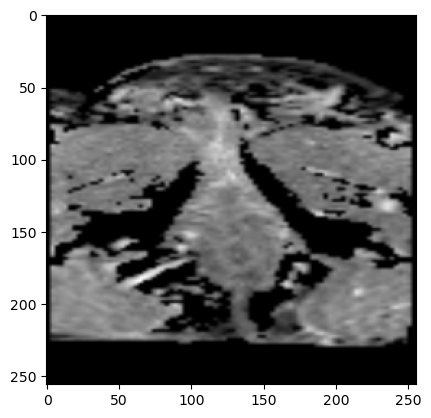

In [113]:
test_image = adc['10017']
print(test_image.shape)

resize = cv2.resize(test_image[0], (256, 256))
print(resize.shape)

plt.imshow(test_image[0], cmap='gray')
plt.show()

plt.imshow(resize, cmap='gray')
plt.show()


### Standardise All Image Dimensions

### Read CSV

In [7]:
path = '/Users/yenhann/Documents/MIT/6.8300 Computer Vision/CV-prostate-cancer/Data/marksheet.csv'
df = pd.read_csv(path)
df.head()

# filter down to relevant studies
suffices = ['00','01','03','06','17','20','22','23','27','29','32','33','35','38','40','41']
prefix1 = '100'
prefix2 = '10000'
rel_studies = pd.DataFrame()

for i in suffices:
    patient_id = int(prefix1 + i)
    study_id = int(prefix2 + i)

    # find the row in the dataframe and append to rel_studies
    rel_studies = rel_studies.append(df[(df['patient_id'] == patient_id) & (df['study_id'] == study_id)])

rel_studies

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
6,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0+0,3+3","0,1",1,NO
17,10017,1000017,2012-09-21,67,5.50,NaN,NaN,NaN,NaN,NaN,0,NO
20,10020,1000020,2017-02-24,43,4.60,0.11,47.0,NaN,NaN,NaN,0,NO
22,10022,1000022,2019-05-24,56,5.00,NaN,25.0,MRBx,3+3,1,1,NO
23,10023,1000023,2013-01-02,62,1.50,0.03,37.0,MRBx,0+0,0,0,NO
27,10027,1000027,2019-09-23,63,7.40,NaN,37.0,MRBx,0+0,0,0,NO
29,10029,1000029,2017-10-15,64,8.90,0.20,46.0,SysBx+MRBx,"3+4,4+5,3+3","2,5,1",5,YES


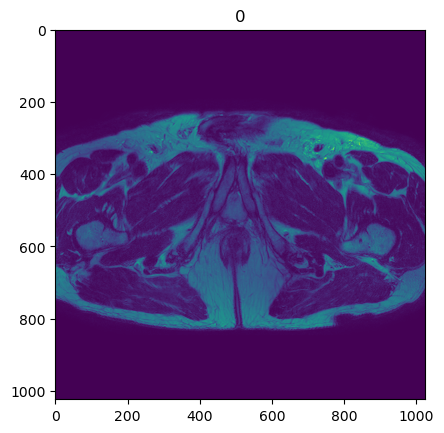

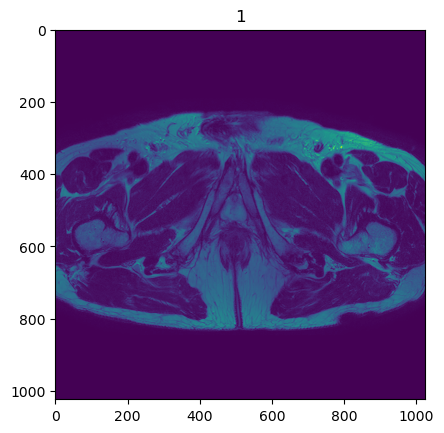

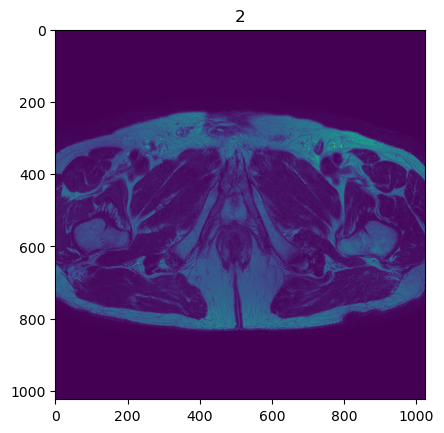

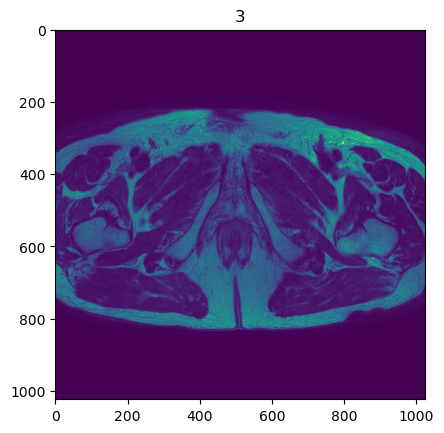

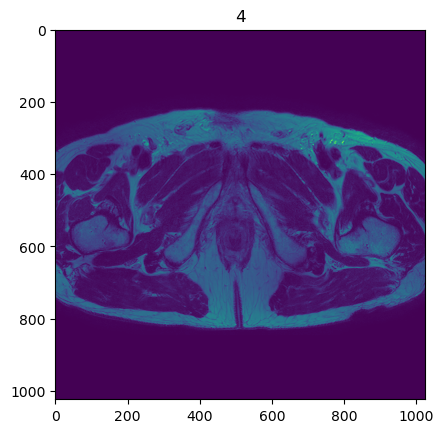

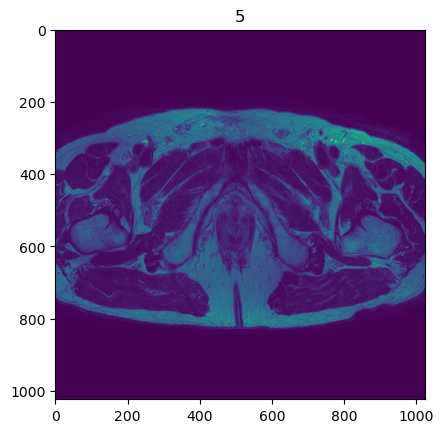

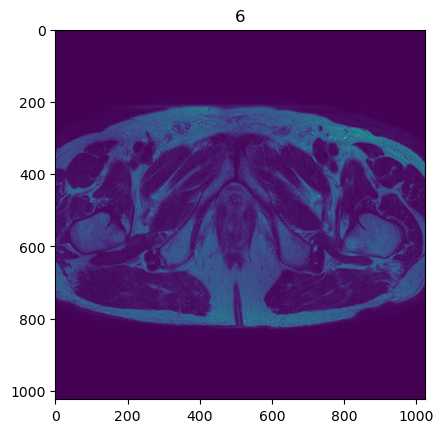

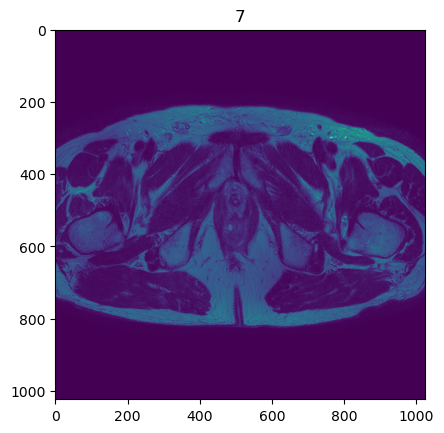

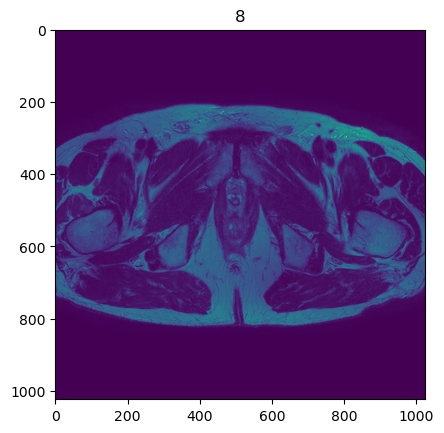

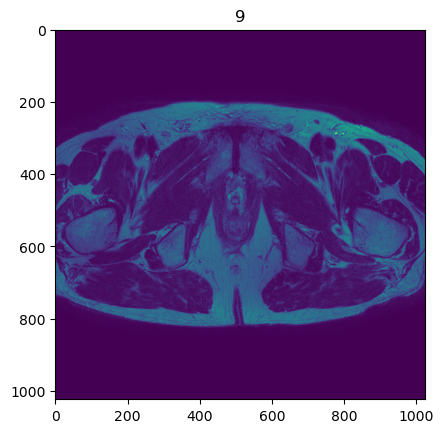

In [6]:
# look at first 10 images
for i in range(0,10):
    plt.imshow(img[i,:,:])
    plt.title(str(i))
    plt.show()